In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shreyaakuu_har25indoor_path = kagglehub.dataset_download('shreyaakuu/har25indoor')

print('Data source import complete.')


In [ ]:
model_checkpoint = "apple/mobilevitv2-1.0-imagenet1k-256" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [ ]:
!pip install -q datasets transformers accelerate

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

/tmp/ipykernel_34/1780215247.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/kaggle/input/har25indoor/HARDATA_SHREYA")

Resolving data files:   0%|          | 0/5480 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
train_ds = dataset['train']
splits = train_ds.train_test_split(test_size=0.15)
train_ds = splits['train']
val_ds = splits['test']
splits2 = train_ds.train_test_split(test_size=0.15)
train_ds = splits2['train']
test_ds = splits2['test']

In [ ]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Washing Dishes',
 1: 'applauding',
 2: 'brushing teeth',
 3: 'cleaning the floor',
 4: 'cooking',
 5: 'cutting veggies',
 6: 'dancing',
 7: 'drinking',
 8: 'eating',
 9: 'fighting',
 10: 'hugging',
 11: 'laughing',
 12: 'phoning',
 13: 'pouring a liquid',
 14: 'reading',
 15: 'sitting',
 16: 'sleeping',
 17: 'smoking',
 18: 'taking photos',
 19: 'texting',
 20: 'using a computer',
 21: 'watching tv',
 22: 'waving hands',
 23: 'writing on a board',
 24: 'writing on a book'}

In [ ]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

2024-06-15 05:34:25.088976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 05:34:25.089084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 05:34:25.199756: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

MobileViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "segmentation_maps",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_center_crop",
    "crop_size",
    "do_flip_channel_order",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "crop_size": {
    "height": 256,
    "width": 256
  },
  "do_center_crop": true,
  "do_flip_channel_order": true,
  "do_rescale": true,
  "do_resize": true,
  "image_processor_type": "MobileViTImageProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 288
  }
}

In [ ]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

# Define mean and std for normalization (example values)
image_mean = [0.485, 0.456, 0.406]  # Example mean for ImageNet
image_std = [0.229, 0.224, 0.225]   # Example std for ImageNet
size = 256  # Example size, you can adjust it as needed

normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

_val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples



In [ ]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [ ]:
from transformers import MobileViTV2ForImageClassification, TrainingArguments, Trainer

model = MobileViTV2ForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

config.json:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/19.8M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of MobileViTV2ForImageClassification were not initialized from the model checkpoint at apple/mobilevitv2-1.0-imagenet1k-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([25, 512]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([25]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 256, 256])
labels torch.Size([4])


In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-mobilevitv2",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=15,
    weight_decay=0.1,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
0,3.215800,3.200657,0.074390
2,3.134500,3.067302,0.258537
4,2.991100,2.873914,0.408537
6,2.790300,2.598362,0.440244
8,2.538900,2.327754,0.456098
10,2.298800,2.148212,0.486585
12,2.210900,2.063080,0.496341
14,2.186900,2.049890,0.493902


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=225, training_loss=2.6672390704684785, metrics={'train_runtime': 1025.0515, 'train_samples_per_second': 57.729, 'train_steps_per_second': 0.22, 'total_flos': 2.974112319185879e+17, 'train_loss': 2.6672390704684785, 'epoch': 14.516129032258064})

In [ ]:
outputs = trainer.predict(test_ds)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
print(outputs.metrics)

{'test_loss': 2.05853009223938, 'test_accuracy': 0.48206599713055953, 'test_runtime': 8.106, 'test_samples_per_second': 85.986, 'test_steps_per_second': 1.357}


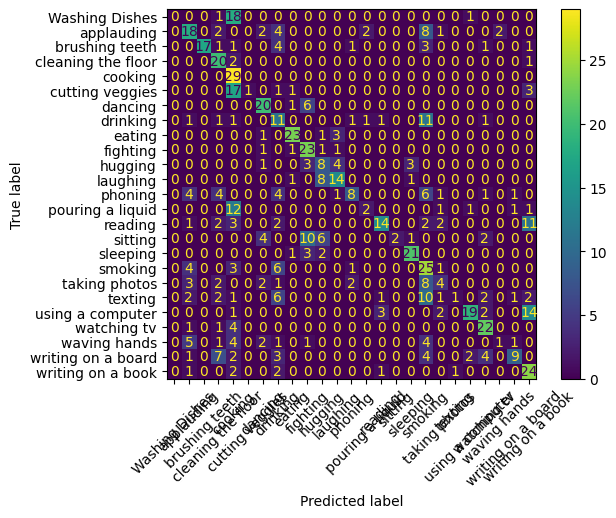

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.44      0.46      0.45        39
           2       1.00      0.59      0.74        29
           3       0.45      0.87      0.60        23
           4       0.29      1.00      0.45        29
           5       1.00      0.04      0.08        23
           6       0.61      0.74      0.67        27
           7       0.24      0.38      0.30        29
           8       0.82      0.82      0.82        28
           9       0.50      0.85      0.63        27
          10       0.31      0.42      0.36        19
          11       0.61      0.58      0.60        24
          12       0.62      0.27      0.37        30
          13       0.40      0.11      0.17        18
          14       0.70      0.38      0.49        37
          15       1.00      0.08      0.15        25
          16       0.81      0.78      0.79        27
          17       0.31    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
